### To determine the contents of a file:

In [2]:
# imports
%matplotlib inline
import os
import pandas as pd
import numpy as np #import to take 2nd derivative as I don't think this occured, Jeff 2.28.2022 
import scipy

import sys
#maybe need to do this in case I change the path at the end for saving elsewhere?
os.chdir(r'C:\Users\jrosh\Documents\FTIR_Mapping\ftir')
sys.path.append("../")

import ftir.modeling.peak_fitting as peak_fitting
from ftir.modeling.buffer_subtraction import find_buffer_subtraction_constant, buffer_subtract
from ftir.modeling.peak_fitting import gaussian_minimize, gaussian_differential_evolution, gaussian_least_squares
from ftir.modeling.peak_fitting import secondary_structure, create_fit_plots, gaussian_list, sd_baseline_correction, gaussian_integral, gaussian_sum
from ftir.modeling.peak_fitting import create_fit_singleplot #added this to avoid additional layer of subplotting of residuals
# from ftir.modeling.peak_definitions import yang_h20_2015, dong_h2o_1990, yang_list
from ftir.io.utils import create_df_from_single_file

import math
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.spatial import ConvexHull

import time
import tkinter as tk
from tkinter import *
from tkinter import filedialog

import seaborn as sns

import opusFC

f = r"C:\Users\jrosh\Box\FTIR\Structural Mapping\8.4.2022CoffeeRing\Attempt2.0"
dbs = opusFC.listContents(f)
print(dbs)
dbs[1]

[('AB', '3D', 'NONE'), ('SSC', '3D', 'NONE'), ('RSC', '2D', 'NONE'), ('TRC', '3D', 'NONE')]


('SSC', '3D', 'NONE')

### Load the first datablock in dbs: 

In [3]:
data = opusFC.getOpusData(f, dbs[1])
data.regions

[Region 1 (9 x 3), Region 2 (5 x 3)]

In [4]:
data.regions[1].mapX[:]

array([ 6676.22021484, 10539.06738281, 14401.9140625 , 18264.76171875,
       22127.609375  ,  6676.22021484, 10539.06738281, 14401.9140625 ,
       18264.76171875, 22127.609375  ,  6676.22021484, 10539.06738281,
       14401.9140625 , 18264.76171875, 22127.609375  ])

#####This is the money part: extracting x and y data

In [5]:
#make a dictionary of x-y location data
list_of_regions=[]
x_coordinates = []
y_coordinates = []
for j in range(len(data.regions)):

    x_coordinates = np.append(x_coordinates, data.regions[j].mapX[:])
    y_coordinates = np.append(y_coordinates, data.regions[j].mapY[:])
    for i in range(len(data.regions[j].mapX)):

        list_of_regions.append(j+1) #data.regions[j].split())
        
    #list_of_regions = i in range(len(data.regions[j].mapX))
#xydict = {'region':list_of_regions,'x_coordinate':data.regions[0].mapX[:],'y coordinate':data.regions[0].mapY[:]}#,data.x:data.regions[0].spectra[:]}
xydict = {'region':list_of_regions,'x coordinate':x_coordinates,'y coordinate':y_coordinates}#,data.x:data.regions[0].spectra[:]}
len(list_of_regions)

42

In [6]:
#Make a loop or use a fancy 1 liner to take all of the X and Y data from here and then put it in a dataframe as the first 2 rows, or maybe the 2nd and 3rd rows 
# (probably best to have name/title of column, then x, then y, then data)
xypositions_df = pd.DataFrame(data=xydict)#[data.regions[0].mapX[:],data.regions[0].mapY[:]])
xypositions_df.head(40)

,region,x coordinate,y coordinate
0,1,5603.669922,2015.540039
1,1,5702.126465,2015.540039
2,1,5800.583008,2015.540039
3,1,5899.039551,2015.540039
4,1,5997.496094,2015.540039
5,1,6095.952637,2015.540039
6,1,6194.409180,2015.540039
7,1,6292.865723,2015.540039
8,1,6391.322266,2015.540039
9,1,5603.669922,2283.677002


In [7]:
type(data.regions[0].spectra[:])

numpy.ndarray

In [16]:
#make dataframe of actual spectra, multiple regions
spectra_df = pd.DataFrame()
spectra_listed_df = pd.DataFrame()
print('data regions len:' ,len(data.regions))
for i in range(len(data.regions)): 
  #  print(data.regions[i].spectra[:])
    spectra_df = pd.concat([spectra_df,pd.DataFrame(data.regions[i].spectra[:])])
    spectra_listed_df = pd.concat([spectra_df,data.regions[i].spectra[:]])

#data.regions[].spectra[:]
spectra_df


tspectra_df =spectra_df.transpose()
#spectra_df
labeledspectra_df = tspectra_df.set_index(data.x)#what does drop do here? seemingly nothing
#spectra_df['wavenumber'] = data.x

tlabeledspectra_df = labeledspectra_df.transpose()
tlabeledspectra_df.index = tlabeledspectra_df.index.set_names(['Index within Region'])
tlabeledspectra_df = tlabeledspectra_df.reset_index(col_fill="index for region")

tlabeledspectra_df

data.regions[1].spectra[14]

data regions len: 2


TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

In [18]:
data.x
wavenumber_df = pd.DataFrame(data.x)
wavenumber_df.iloc[2]

,0
0,3998.516413
1,3997.088371
2,3995.660329
3,3994.232288
4,3992.804246
...,...
2376,605.489628
2377,604.061587
2378,602.633545
2379,601.205503


In [19]:
#Make a df with all info (region number, x&y coordinates, index within region, and then intensity for all wavenumbers)
twodfs = [xypositions_df, tlabeledspectra_df]

complete_df = pd.concat(twodfs, axis=1,join='inner')
#complete_df
#complete_df[complete_df["region"]>1]
complete_df.transpose().iloc[4:]

NameError: name 'tlabeledspectra_df' is not defined

In [11]:
complete_df.iloc[4:]

NameError: name 'complete_df' is not defined

In [12]:
#Maybe it's best to do some math, then to transpose back the matrix and then add on x and y data and remove any issues with the index?
complete_transposed_wavenumberfirstcolumn_df = complete_df.transpose().iloc[4:]
complete_transposed_wavenumberfirstcolumn_df = complete_transposed_wavenumberfirstcolumn_df.reset_index()

#baseline correction 
sd_baseline_correction(complete_transposed_wavenumberfirstcolumn_df, cols = list(range(len(complete_df))),flip=False, method='rubberband', bounds=(1715, 1595),freq='Index')

#

NameError: name 'complete_df' is not defined

In [13]:
spectra_df
wavenumber_reindex = ['Wavenumber' + str(n) for n in range(len(data.x))]
wavenumber_reindex
spectra_reindexed_df = spectra_df
spectra_reindexed_df.columns= wavenumber_reindex
spectra_reindexed_df.head(4)
# wavenumber_reindexed_spectra_df = 

,Wavenumber0,Wavenumber1,Wavenumber2,Wavenumber3,Wavenumber4,Wavenumber5,Wavenumber6,Wavenumber7,Wavenumber8,Wavenumber9,...,Wavenumber2371,Wavenumber2372,Wavenumber2373,Wavenumber2374,Wavenumber2375,Wavenumber2376,Wavenumber2377,Wavenumber2378,Wavenumber2379,Wavenumber2380
0,0.450608,0.446442,0.442394,0.440009,0.438879,0.439040,0.441915,0.447218,0.451534,0.451986,...,0.048871,0.048008,0.046764,0.045352,0.043842,0.042236,0.040423,0.038270,0.035896,0.033662
1,0.443068,0.438975,0.434961,0.432567,0.431418,0.431545,0.434341,0.439537,0.443788,0.444263,...,0.048647,0.047797,0.046573,0.045188,0.043677,0.042017,0.040136,0.037961,0.035612,0.033399
2,0.436386,0.432401,0.428464,0.426071,0.424868,0.424941,0.427686,0.432813,0.437006,0.437481,...,0.050558,0.049824,0.048655,0.047223,0.045583,0.043788,0.041849,0.039701,0.037402,0.035193
3,0.458521,0.454302,0.450143,0.447644,0.446430,0.446530,0.449387,0.454760,0.459216,0.459801,...,0.051899,0.051095,0.049862,0.048361,0.046642,0.044763,0.042726,0.040460,0.038052,0.035777


In [14]:
#dataframe with index for 4000cm^-1 starting at 0, instead of the wavenumber itself
complete_nowavenumberindex_df = xypositions_df.join(spectra_reindexed_df)
complete_nowavenumberindgex_df.head(4)

NameError: name 'complete_nowavenumberindgex_df' is not defined

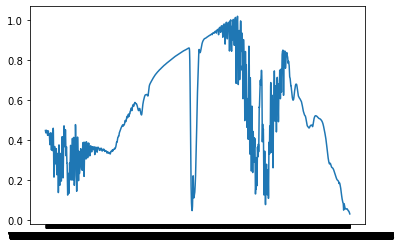

In [23]:
#Test Plot 
fig,ax = plt.subplots()
# ax.plot(x, complete_nowavenumberindex_df.iloc[3][3:])
ax.plot(complete_nowavenumberindex_df.iloc[3][3:])

In [183]:
complete_nowavenumberindex_df.iloc[3]

region               1.000000
x coordinate      5702.126465
y coordinate      2015.540039
Wavenumber0          0.449126
Wavenumber1          0.445030
                     ...     
Wavenumber2376       0.039947
Wavenumber2377       0.038109
Wavenumber2378       0.036063
Wavenumber2379       0.033872
Wavenumber2380       0.031741
Name: 1, Length: 2384, dtype: float64

In [32]:
#test some math from actual FTIR script

#only show between 1715 and 1595
baseline_corrected_AmideI_df = pd.DataFrame()

for cols in complete_nowavenumberindex_df.iloc[1].transpose(): 
    #complete_nowavenumberindex_df.iloc[1].transpose()
    print(cols)
    sd_baseline_correction(complete_nowavenumberindex_df.iloc[1].transpose(),cols=[cols_], flip=False, method='rubberband', bounds=('Wavenumber500', 'Wavenumber600'))
    
# for cols_ in wnrawData_df.columns[1:]:
#     sd_baseline_correction(complete_nowavenumberindex_df.iloc[1].transpose(),cols=[cols_], flip=False, method='rubberband', bounds=('Wavenumber500', 'Wavenumber600'))

# for cols_ in wnrawData_df.columns[1:]:
#     baseline_corrected_AmideI.append(sd_baseline_correction(wnrawData_df, cols=[cols_], flip=False, method='rubberband', bounds=(1715, 1595)))

# print(rawData_df.columns)

1.0
5603.669921875
2015.5400390625
0.45918017625808716
0.4549245238304138
0.4506819546222687
0.44811367988586426
0.4468997120857239
0.44707751274108887
0.4500194191932678
0.4553976356983185
0.45977216958999634
0.4602660536766052
0.4578445255756378
0.45569586753845215
0.4555602967739105
0.4558149576187134
0.45288729667663574
0.44569650292396545
0.4381101727485657
0.43496179580688477
0.43691056966781616
0.44143474102020264
0.4469473958015442
0.45305460691452026
0.45750534534454346
0.45608586072921753
0.44786784052848816
0.4386889934539795
0.43535399436950684
0.4378117322921753
0.44135624170303345
0.4434933662414551
0.44345131516456604
0.43814170360565186
0.4240718185901642
0.4037376344203949
0.3879726231098175
0.386777400970459
0.39530664682388306
0.3981274366378784
0.3923187851905823
0.3929445743560791
0.409673273563385
0.4330213665962219
0.44787752628326416
0.44616246223449707
0.4259858727455139
0.3932947516441345
0.3651920557022095
0.3592892587184906
0.37489980459213257
0.390774518251

In [25]:
complete_nowavenumberindex_df.iloc[1].transpose()

region               1.000000
x coordinate      5603.669922
y coordinate      2015.540039
Wavenumber0          0.459180
Wavenumber1          0.454925
                     ...     
Wavenumber2376       0.041227
Wavenumber2377       0.039341
Wavenumber2378       0.037228
Wavenumber2379       0.034945
Wavenumber2380       0.032750
Name: 0, Length: 2384, dtype: float64

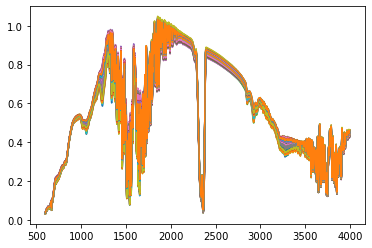

ValueError: x and y must have same first dimension, but have shapes (2381,) and (2383,)

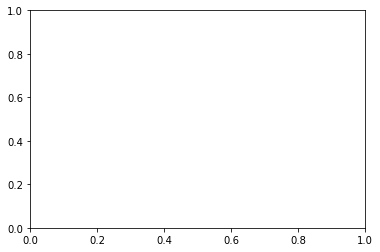

In [16]:
(complete_df.T).to_csv(r'C:\Users\jrosh\Documents\FTIR_Mapping\Results\test.csv')

x = [key for key in complete_df.keys() if type(key) == float]
complete_df[x]

fig, ax = plt.subplots()    # create figure and axes
for index, row in complete_df[x].iterrows(): 
    ax.plot(x, row)
plt.show()

plt.plot(x,complete_df.iloc[2][2:])

In [157]:
# complete_df.columns[2:]

In [160]:
# complete_df.iterrows()
# complete_df.iloc[3,:][2:]

In [159]:
# complete_df[3]

In [88]:
loc = list(map(float, complete_df.columns[2:]))


print(len(complete_df.columns[2:]))
print(len(loc))
print(complete_df.loc[1,[2:]])

fig, ax = plt.subplots()
for row in complete_df.iterrows():
    ax.scatter(row[1], loc, label=row[1].name)

plt.legend()    
plt.show()

SyntaxError: invalid syntax (Temp/ipykernel_18396/3602723537.py, line 5)

ValueError: x and y must be the same size

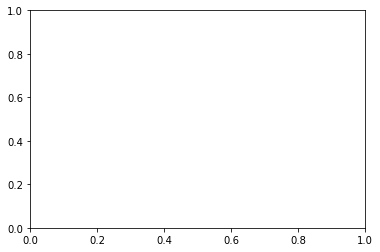

In [70]:
fig, ax = plt.subplots()
# for row in complete_df.iterrows():
#     ax.scatter(row[1], complete_df.columns[2:] , label=row[1].name)

ax.scatter(complete_df.iloc[1,:], complete_df.columns[2:] , label=row[1].name)
complete_df.iloc[1,:]

plt.legend()    
plt.show()

### Access loaded data and parameters:

In [ ]:
data.x                    # X coordinates
data.parameters['SNM']    # Sample name
data.description          # Description of data object
opusFC.paramDict['SNM']     # String description of SNM

### Access and save visible images:

In [ ]:
images = opusFC.getVisImages(f)

for img in images:
    data = img['image']
    title = img['Title']
    imgext = img['imgext']
    f = "{0}_{1}.{2}".format(f, title, imgext)
    with open(f, 'wb') as fd:
        fd.write(data)

In [ ]:
d_db = pd.DataFrame()
bt = tuple()
for things in dbs:
    print(opusFC.getOpusData(f,things))

In [ ]:
opusFC.MultiRegionTRCDataReturn(labels, regions, **kwds)